# Business Understanding
Stackoverflow is a Q&A website aimed to software developers.

*Every year, Stack Overflow conducts a massive survey of people on the site, covering all sorts of information like programming languages, salary, code style and various other information. This year, they amassed more than 64,000 responses fielded from 213 countries. - [Dataset description](https://www.kaggle.com/stackoverflow/so-survey-2017)*

In this notebook we will explore the survey dataset from 2017.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.shape

/Users/jescobedo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(51392, 154)

# Data understanding
For our exploration of the data we will choose the developer type columns

In [2]:
df.columns

Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'StackOverflowMakeMoney', 'Gender', 'HighestEducationParents', 'Race',
       'SurveyLong', 'QuestionsInteresting', 'QuestionsConfusing',
       'InterestedAnswers', 'Salary', 'ExpectedSalary'],
      dtype='object', length=154)

In [3]:
devDf = df[['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType']]
devDf.head()

,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Other,NaN,NaN,NaN
3,NaN,NaN,NaN,Data scientist
4,Mobile developer; Graphics programming; Deskto...,NaN,NaN,NaN


We can see there are tons of missing values, we will begin by cleaning these columns

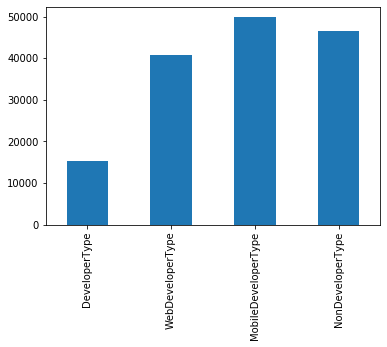

In [4]:
devDf.isna().sum().plot(kind='bar');

First we drop the rows with all missing values, since we are interested in exploring the developer types. 

We dropped almost a fifth of the rows.

In [5]:
dropedNa = df.dropna(subset = ['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType'], how='all')
print('{0} rows droped'.format(df.shape[0] - dropedNa.shape[0]))

10379 rows droped


In [6]:
dropedNa[['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType']].head()

,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType
2,Other,NaN,NaN,NaN
3,NaN,NaN,NaN,Data scientist
4,Mobile developer; Graphics programming; Deskto...,NaN,NaN,NaN
6,NaN,NaN,NaN,Data scientist
7,Web developer,Full stack Web developer,NaN,NaN


The unique values on the dev and non dev columns are:

In [7]:
dropedNa['NonDeveloperType'].str.split(';\s*', expand=True).stack().unique()

array(['Data scientist', 'Other', 'C-suite executive', 'Product manager',
       'Educator or academic', 'Analyst or consultant',
       'Marketing or sales manager', 'Designer or illustrator',
       'Elected official'], dtype=object)

In [8]:
dropedNa['DeveloperType'].str.split(';\s*', expand=True).stack().unique()

array(['Other', 'Mobile developer', 'Graphics programming',
       'Desktop applications developer', 'Web developer',
       'Embedded applications/devices developer', 'DevOps specialist',
       'Quality assurance engineer', 'Data scientist',
       'Machine learning specialist',
       'Developer with a statistics or mathematics background',
       'Database administrator', 'Systems administrator',
       'Graphic designer'], dtype=object)

From the previous **head()** it seems that those people with non developer type jobs aren't developers. To prove it we first select the developers, and out of all the developers we count those with a value on the **NonDeveloperType** column

In [9]:
dropedNa[dropedNa['DeveloperType'].notna()][['DeveloperType','NonDeveloperType']].count()

DeveloperType       36125
NonDeveloperType        2
dtype: int64

Let's see who are them

In [10]:
dropedNa[dropedNa['DeveloperType'].notna()][['DeveloperType','NonDeveloperType']].dropna()

,DeveloperType,NonDeveloperType
22557,Web developer,C-suite executive
36941,Web developer; Mobile developer; Desktop appli...,C-suite executive; Other


What about the other columns?

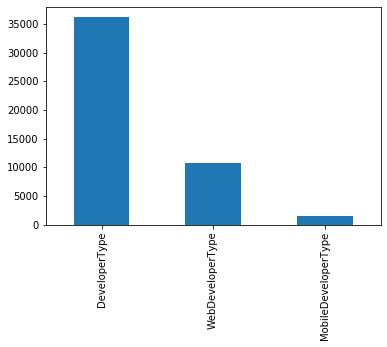

In [11]:
dropedNa[dropedNa['DeveloperType'].notna()][['DeveloperType','WebDeveloperType','MobileDeveloperType']].count().plot(kind='bar');

# Data preparation
*NonDeveloperType* people aren't considered developers in the dataset, even the data scientists in this column aren't considered developers. We can mix the two columns if we were to analize all the type of jobs, or only the data scientist that exist in this column since it also exist in the *DeveloperType* column. In this case, we are going to do the former because we are only interested on data scientists. We will give them a new name.

There are 3045 data scientist in DeveloperType and 1100 in NonDeveloperType


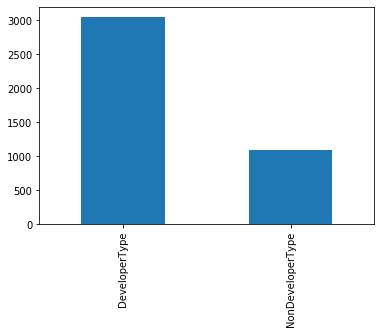

In [12]:
dsInDev = dropedNa['DeveloperType'].str.contains('Data scientist', na=False)
dsInNonDev = dropedNa['NonDeveloperType'].str.contains('Data scientist', na=False) 
print('There are {0} data scientist in DeveloperType and {1} in NonDeveloperType'.format(dropedNa[dsInDev].shape[0], dropedNa[dsInNonDev].shape[0]))
dropedNa[dsInDev | dsInNonDev][['DeveloperType','NonDeveloperType']].count().plot(kind='bar');

In [13]:
dropedNa.loc[dropedNa['NonDeveloperType'].str.contains('Data scientist', na=False), 'DeveloperType'] = 'Non dev data scientist'

/Users/jescobedo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Our target variable are the developers, we are not interested on people who don't know or doesn't respond this question. We drop the null values to further clean the dataset

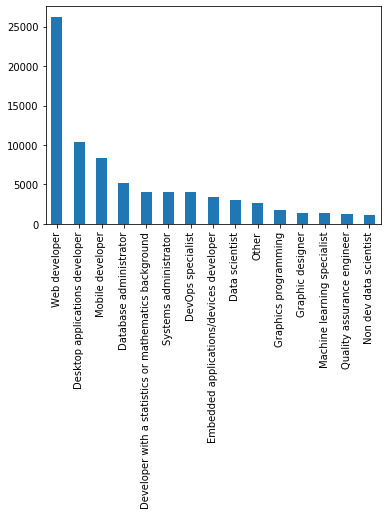

In [14]:
dropedNa = dropedNa.dropna(subset=['DeveloperType'])
dropedNa['DeveloperType'].str.split(';\s*', expand=True).stack().value_counts().plot(kind='bar')

## Question 1
What categorical characteristics describe the two kind of data scientists?

In [15]:
scientist = dropedNa.drop(dropedNa[~dropedNa['DeveloperType'].str.contains('ata scientist', na=False)].index)
scientist.loc[scientist['DeveloperType'].str.contains('Non dev data scientist', na=False), 'DeveloperType'] = 'nonDev'
scientist.loc[scientist['DeveloperType'].str.contains('Data scientist', na=False), 'DeveloperType'] = 'dev'

In [16]:
def plot(df, group, x):
    '''
    Create a bar plot for the counts of the characteristic. Size of the bar is given in percentages.

    Parameters:
    df : Dataframe
    group: Categorical column, one column is created for each group and each value in x axis
    x: Categorical column that contains the caracteristics to be ploted

    '''
    counts = (df.groupby([group])[x]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index())
    p = sns.barplot(x=x, y="percentage", hue=group, data=counts)
    _ = plt.setp(p.get_xticklabels(), rotation=45, horizontalalignment='right')  # Rotate labels

1. The non developer scientists sometimes write code

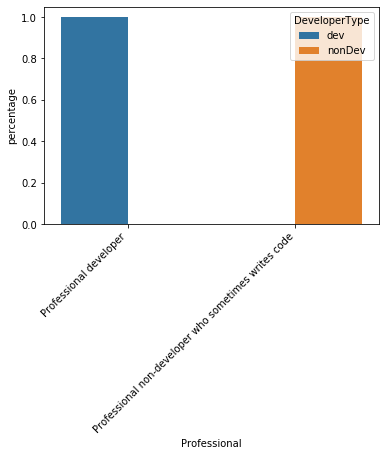

In [17]:
plot(scientist, 'DeveloperType','Professional')

#### Conclusion 1
On this dataset just by looking at the Professional plot, we can tell the scientist that are developers and those who aren't. These two columns are highly correlated in the data scientist subset.

2. In percentages, non developer data scientists have higher education than those that are developers

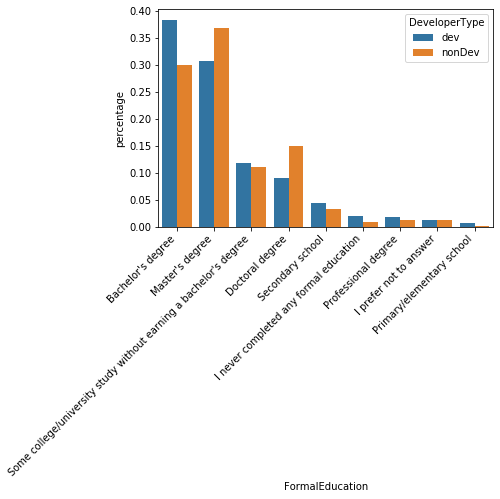

In [18]:
plot(scientist, 'DeveloperType','FormalEducation')

3. There is a huge difference on the MajorUndergrad. Most developers are computer science or software engineers, while there are more non developers in science disciplines.

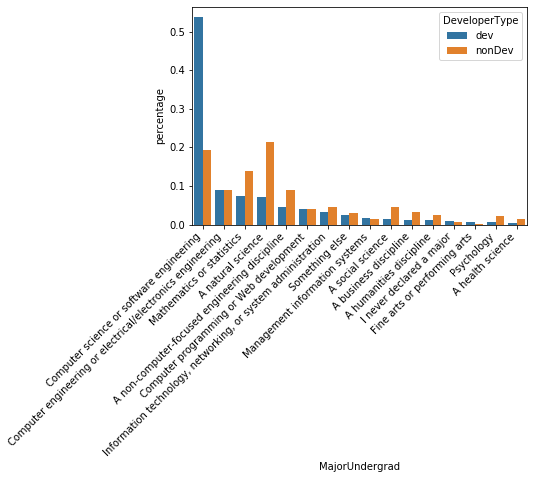

In [19]:
plot(scientist, 'DeveloperType','MajorUndergrad')

4. Government agencies seem to be hiring scientist

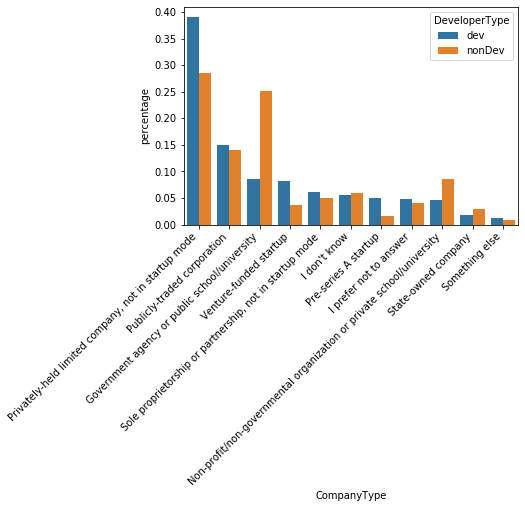

In [20]:
plot(scientist, 'DeveloperType','CompanyType')

5. Company size also threw some interesting results, in average bigger companies have a little more dedicated data scientists that aren't developers

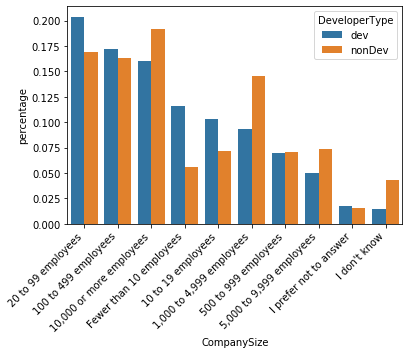

In [21]:
plot(scientist, 'DeveloperType','CompanySize')

6. Developers have coded for longer

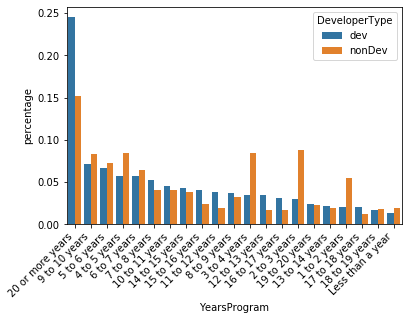

In [22]:
plot(scientist, 'DeveloperType','YearsProgram')

7. Devs are a little happier

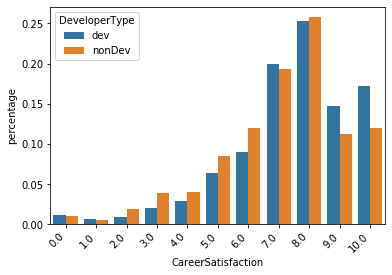

In [23]:
plot(scientist, 'DeveloperType','CareerSatisfaction')

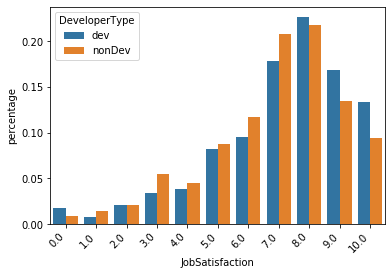

In [24]:
plot(scientist, 'DeveloperType','JobSatisfaction')

8. Developers love engineering, non devs just enjoy it

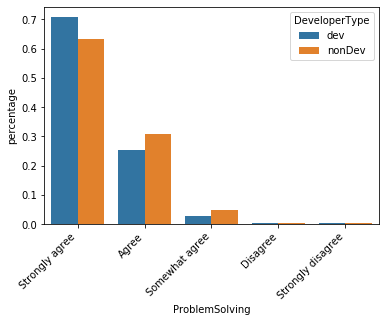

In [25]:
plot(scientist, 'DeveloperType','ProblemSolving')

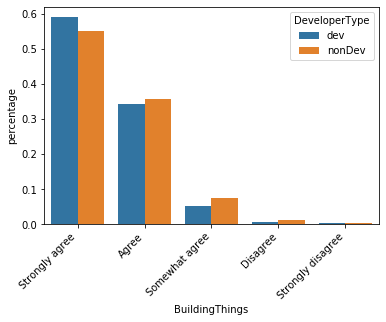

In [26]:
plot(scientist, 'DeveloperType','BuildingThings')

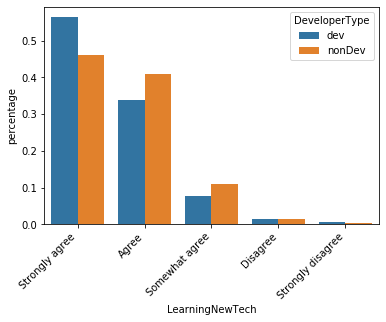

In [27]:
plot(scientist, 'DeveloperType','LearningNewTech')

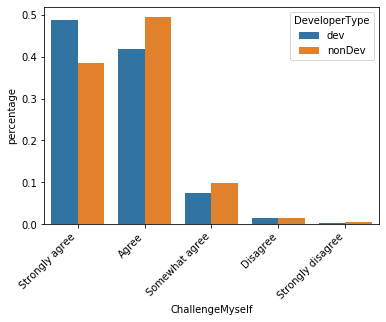

In [28]:
plot(scientist, 'DeveloperType','ChallengeMyself')

9. They are perfectionists

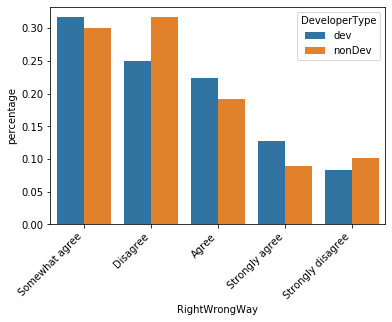

In [29]:
plot(scientist, 'DeveloperType','RightWrongWay')

10. They understand computers

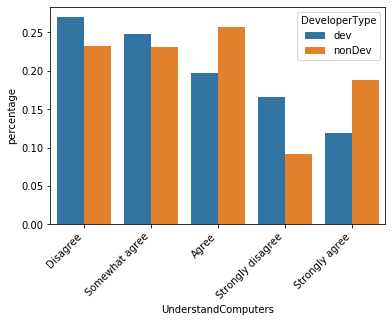

In [30]:
plot(scientist, 'DeveloperType','UnderstandComputers')

11. There is dev hunt going on

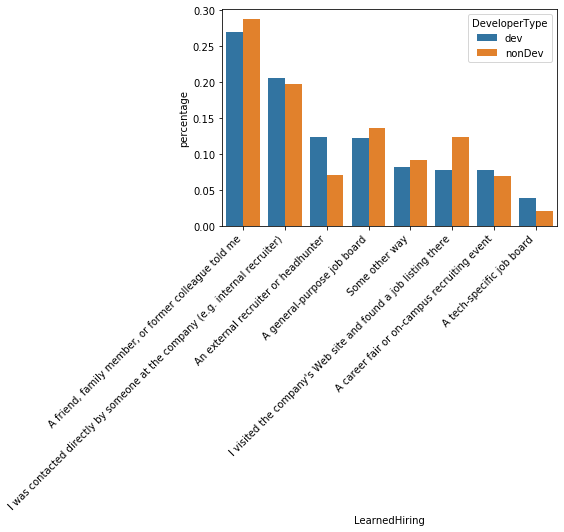

In [31]:
plot(scientist, 'DeveloperType','LearnedHiring')

12. Bootcamp also helps

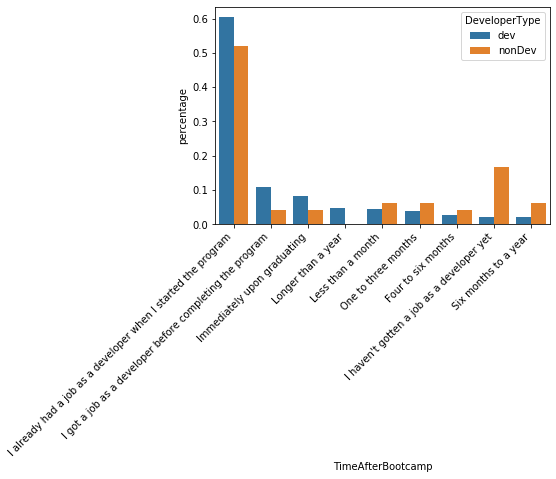

In [32]:
plot(scientist, 'DeveloperType','TimeAfterBootcamp')

13. They are into helping (or judging) others, or perhaps they just love the challenge

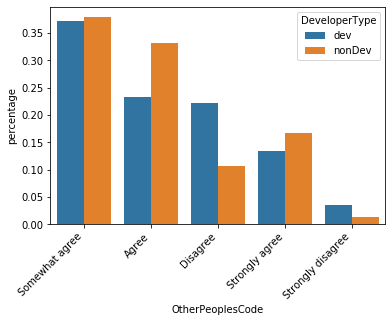

In [33]:
plot(scientist, 'DeveloperType','OtherPeoplesCode')

14. Yes, they just love the challenge

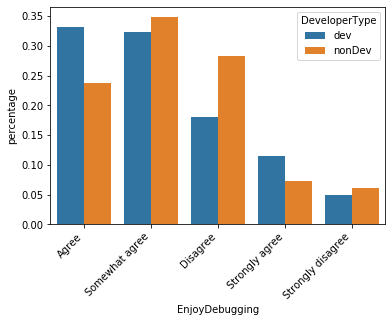

In [34]:
plot(scientist, 'DeveloperType','EnjoyDebugging')

15. Of course, coding is a life style

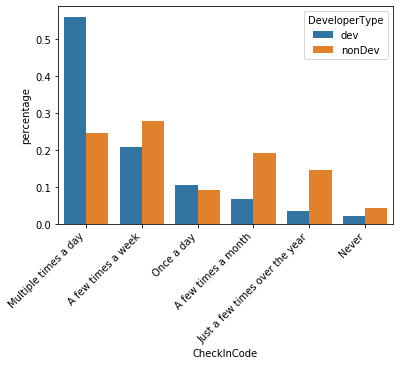

In [35]:
plot(scientist, 'DeveloperType','CheckInCode')

#### Conclusion 2
Ploting each combination is time consuming and tedious. In the previous plots, all the plots that didn't seem to have a big difference were removed. This decission was based in a personal opinion after observing the plots, this can be dangerous since sometimes humans can't see deeper into data.

We can use some feature selection algorithm to find the characteristics that work the best to predict if someone is a developer datascientist, or a non developer data scientist. [Sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) comes with some algorithms, or we could also use a correlation matrix.

The next is the top 20 features using SelectKBest algorithm and chi2 from sklearn. This is done only on categorical variables.

In [36]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

def getScore(df, target):
    dropedTarget = df.drop(target, axis=1).select_dtypes(include='object').fillna('')
    oe = OrdinalEncoder()
    oe.fit(dropedTarget)
    X = oe.transform(dropedTarget)

    y = df[target]
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)

    fs = SelectKBest(score_func=chi2, k='all')
    fit = fs.fit(X, y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(dropedTarget.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score'] 
    print(featureScores.nlargest(20,'Score'))
getScore(scientist, 'DeveloperType')

                   Specs          Score
103         MetricAssess  186438.981938
15      NonDeveloperType   50668.800000
83    HaveWorkedLanguage   30102.577549
84      WantWorkLanguage   10979.381277
93           Methodology    9693.787170
74              Currency    5437.142857
85   HaveWorkedFramework    4859.799026
62        ResumePrompted    3307.224959
0           Professional    3045.000000
86     WantWorkFramework    2328.553459
77    EducationImportant    2116.912972
87    HaveWorkedDatabase    1932.789197
90      WantWorkPlatform    1770.857408
89    HaveWorkedPlatform    1620.460697
75              Overpaid    1361.904762
81       CousinEducation     930.224469
91                   IDE     413.473507
88      WantWorkDatabase     252.901147
79       SelfTaughtTypes     171.039833
95           CheckInCode     164.115883


If we try to plot a few features, we notice that they only describe one class.

Of course, these are data scientists not considered developers.

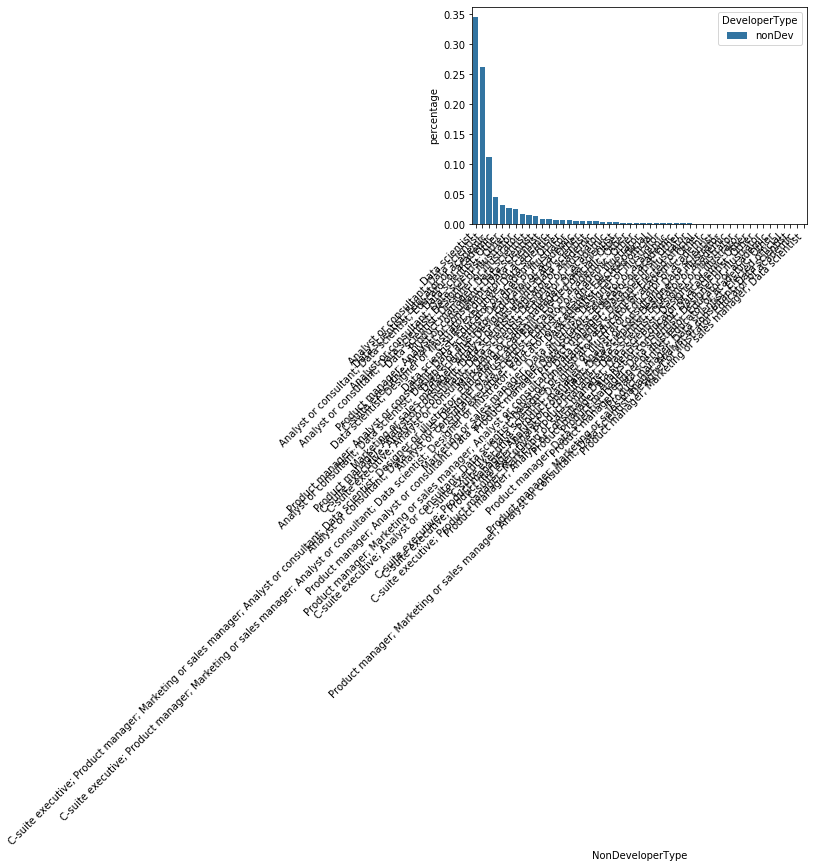

In [37]:
plot(scientist, 'DeveloperType','NonDeveloperType')

This is a mess, but after reading the description we see why this feature can also predict easily the data scientist type
> Congratulations! The bosses at your new employer, E Corp, are allowing you to choose which metrics will be used to assess your individual performance in your role as a **senior developer**. Which metrics do you suggest to the E bosses?

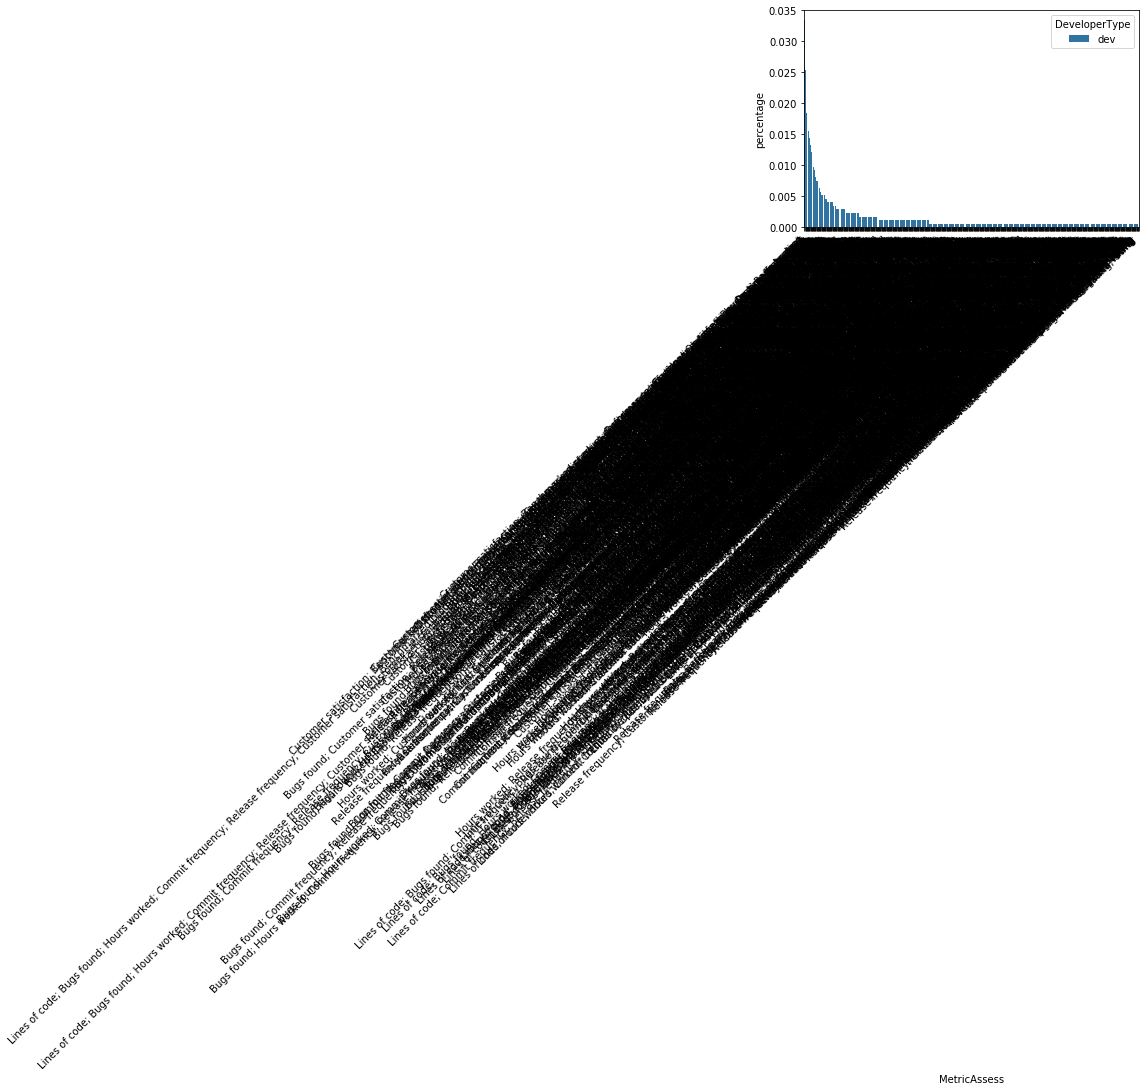

In [38]:
plot(scientist, 'DeveloperType','MetricAssess')

### Answer
*What categorical characteristics describe the two kind of data scientists?*

There are questions aimed to developers and questions aimed to those who are not developers. These are the top 5 characteristics that describe the best the two kind of scientists.

- MetricAssess
- NonDeveloperType
- HaveWorkedLanguage 
- WantWorkLanguage   
- Methodology  

The rest also describe the classes, but in a lower degree.

## Question 2
*Can we predict who is a non developer data scientist and who is a developer data scientist?*

After the previous exploration we don't need a machine learning algorithm to predict who is a data scientist and who is not. But for the sake of the exercise, we will delete the features that are given to a single kind of data scientist (e.g. MetricAssess). And a column whose values are mutually exclusive for the targets (i.e. Professional)

Then we [one-hot-encode](https://bambielli.com/til/2018-02-11-one-hot-encoding/) our categorical variables. This is done to help our machine learning algorithm to predict. If it is not done, some algorithms give numerical values to each category, now each category has some *importance* value, which in turn could affect the predictions. Therefore, we *binarize* the categories to indicate if it's present or not.

In [39]:
y = scientist['DeveloperType']
X = scientist.drop(['Professional'], axis = 1)
for col in scientist:
    series = scientist.groupby(['DeveloperType'])[col].value_counts()
    if 'nonDev' not in series or 'dev' not in series:
        X = X.drop(col, axis=1)
print('Columns dropped: {0}'.format(scientist.shape[1] - X.shape[1]))
getScore(X, 'DeveloperType')

X = X.drop(['DeveloperType'], axis = 1)
for col in X:
    X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
X.shape

Columns dropped: 20
                  Specs         Score
66   HaveWorkedLanguage  30102.577549
67     WantWorkLanguage  10979.381277
76          Methodology   9693.787170
68  HaveWorkedFramework   4859.799026
69    WantWorkFramework   2328.553459
70   HaveWorkedDatabase   1932.789197
73     WantWorkPlatform   1770.857408
72   HaveWorkedPlatform   1620.460697
64      CousinEducation    930.224469
74                  IDE    413.473507
71     WantWorkDatabase    252.901147
62      SelfTaughtTypes    171.039833
78          CheckInCode    164.115883
8           CompanyType    142.676009
48           JobProfile     57.388363
5        MajorUndergrad     30.458736
63    TimeAfterBootcamp     26.548203
22          SeriousWork     23.068851
96    InfluenceDeptTech     22.451135
1               Country     22.284027


(4145, 14372)

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7310012062726177


### Answer
*Can we predict who is a non developer data scientist and who is a developer data scientist?*

Yes, with the other categorical columns and a simple unoptimized model we can pretty much predict the type of data scientist

## Question 3
*Can we predict what kind of workers are there? That is, by joining DeveloperType and NonDeveloperType on the original dataset.*

First we will copy the data scientist from the NonDeveloperType column to the DeveloperType, and change their name. 

Next we mix both columns into one called JobType.

Finally we one hot encode this new target column to try to predict them.

In [116]:
dropedNa = df.dropna(subset = ['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType'], how='all')
dropedNa.loc[dropedNa['NonDeveloperType'].str.contains('Data scientist', na=False), 'DeveloperType'] = 'Non dev data scientist'
dropedNa['JobType'] = dropedNa["DeveloperType"].fillna('') + '; ' + dropedNa["NonDeveloperType"].fillna('')
targetColumns = dropedNa['JobType'].str.get_dummies(sep="; ").columns
dropedNa = pd.concat([dropedNa.drop('JobType', 1), dropedNa['JobType'].str.get_dummies(sep="; ")], 1)

/Users/jescobedo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/jescobedo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

y = dropedNa[targetColumns]
X = dropedNa.drop(['DeveloperType','WebDeveloperType','MobileDeveloperType','NonDeveloperType'], axis = 1)
X = X.drop(targetColumns, axis = 1)
for col in X:
    X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
X.shape

(41013, 79461)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.19602584420334024


### Answer
*Can we predict what kind of workers are there?*

Yes, we can use any algorithm from sklearn to predict a multiclass dataset. 

The accuracy using the defaults was low, but it can be improved by tweaking the parameters of the model or using any other algorithm. 